In [ ]:
#@title
# Only run this once per session (ie. when kernel is restarted)
!pip install tensorflow
!pip install -q sklearn
!pip install xlwt openpyxl xlsxwriter xlrd
!pip install PyDrive
!pip install --upgrade tensorflow-graphics

In [ ]:
%tensorflow_version 2.x
import os
import tensorflow.compat.v2 as tf
import tensorflow.compat.v2.feature_column as fc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from google.colab import files
import io


# Linear Regressor (Input and output layer with 1 hidden layer)




In [ ]:
# load dataset
print("Select file for the training data:")
traincsv = files.upload()
dftrain = pd.read_csv(io.BytesIO(traincsv["training1.csv"]))
dftrain.drop(['batch'], axis = 1)
print("Select file for the evaluation data:")
evalcsv = files.upload()
dfeval = pd.read_csv(io.BytesIO(evalcsv["eval1.csv"]))
dfeval.drop(['batch'], axis = 1)
y_train = dftrain.pop("SF").to_numpy()
y_eval = dfeval.pop("SF").to_numpy()

# Preprocess the non-numerical data
CATEGORICAL_COLUMNS = ['LREE', 'HREE', 'chelant']
NUMERIC_COLUMNS = ['LREE_Concn', 'HREE_Concn', 'CA_ratio', 'Eu_ratio', 'Voltage', 'Initial_volume', 'Test_duration']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
print(feature_columns)


In [ ]:
# Make the input function now
def make_input_fn(data_df, label_df, num_epochs=300, shuffle=True, batch_size=24):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(200)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 24 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

#create the model
linear_est = tf.estimator.LinearRegressor(feature_columns=feature_columns, optimizer=lambda: tf.keras.optimizers.Adam(
        learning_rate=tf.compat.v1.train.exponential_decay(learning_rate=0.1,
            global_step=tf.compat.v1.train.get_global_step(), decay_steps=100, decay_rate=0.96)))


In [ ]:
#train the model now
#tf.keras.backend.set_floatx('float64')
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears console output
print(result)
print("Loss:", result['loss'], "\nAccuracy:", result['prediction/mean']/result['label/mean'] )  # the result variable is simply a dict of stats about our model


In [ ]:
#@title
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
#@title
# try the linear regression model using sklearn

# Preprocess the non-numerical data
CATEGORICAL_COLUMNS = ['LREE', 'HREE', 'chelant']
NUMERIC_COLUMNS = ['LREE_Concn', 'HREE_Concn', 'CA_ratio', 'Eu_ratio', 'Voltage', 'Initial_volume', 'Test_duration']
for i in NUMERIC_COLUMNS:
  FEATURE_COLUMNS = CATEGORICAL_COLUMNS.append(i)
column_trans = make_column_transformer((OrdinalEncoder(FEATURE_COLUMNS)), remainder='passthrough')
lr = LinearRegression(normalize=True)
pipe = make_pipeline(column_trans, lr)
y_pred = lr.predict(dfeval)
mean_squared_error(y_eval, y_pred)

# Deep Neural Network (15 inputs, 2 hidden layer, 3 dense layers)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import linear_model
from keras.metrics import categorical_crossentropy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
#from tensorflow_graphics.math.optimizer import levenberg_marquardt
#drive.mount('/content/drive/')

In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':"1xH_YftrHeiJYev-RLwbJuEjAArpOCW9G"})   # training/eval data during training
downloaded.GetContentFile('REE_data.csv')

batch23056 = drive.CreateFile({'id':"1edCTbOfc1zPQvdIuibVRsqAUMpXWxREH"})
batch23056.GetContentFile('23056_pred.csv')

dataset = pd.read_csv("REE_data.csv")
dataset.head()
dataset.columns = ["SF", "LREE", "HREE", "LREE_Concn", "HREE_Concn", "chelant", "CA_ratio", "Eu_ratio", "Voltage", "Initial_volume", "Test_duration"]

In [ ]:
#Change cetegorical data to numerical through the mapping below
dataset['LREE'] = dataset['LREE'].map({1: "La"})
dataset['HREE'] = dataset['HREE'].map({1: "Eu"})
dataset['chelant'] = dataset['chelant'].map({1: "CDTA", 2: "DTPA", 3: "EDTA", 4: "HEDTA", 5: "None", 6: "NTA"})
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
y = dataset.pop('SF').to_numpy()
x = dataset.to_numpy()

x_train, x_eval, y_train, y_eval = train_test_split(x, y, test_size=0.2, random_state=100)
dataset.head()

#Normalize the dataa
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(x_train))

DNN_model = tf.keras.Sequential([normalizer])
#DNN_model.add(tf.keras.layers.Flatten())
DNN_model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
DNN_model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
#DNN_model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
DNN_model.add(tf.keras.layers.Dense(1))

DNN_model.compile(optimizer=tf.optimizers.Adam(learning_rate = 0.01), loss='mean_absolute_error', metrics=['accuracy'])
#minimize_loss = levenberg_marquardt.minimize(y_train-y_eval)
DNN_model.fit(x, y, batch_size = 20, epochs=300)

history = DNN_model.fit(
    x_train, y_train, 
    epochs=300,
    validation_data=(x_eval, y_eval))

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [SF]')
  plt.title("Loss Over Epochs")
  plt.legend()
  plt.grid(True)


Epoch 1/300
8/8 [==============================] - 1s 3ms/step - loss: 8.4707 - accuracy: 0.0000e+00
Epoch 2/300
8/8 [==============================] - 0s 2ms/step - loss: 6.9133 - accuracy: 0.0000e+00
Epoch 3/300
8/8 [==============================] - 0s 2ms/step - loss: 5.9776 - accuracy: 0.0000e+00
Epoch 4/300
8/8 [==============================] - 0s 2ms/step - loss: 5.9664 - accuracy: 0.0000e+00
Epoch 5/300
8/8 [==============================] - 0s 2ms/step - loss: 5.7120 - accuracy: 0.0000e+00
Epoch 6/300
8/8 [==============================] - 0s 2ms/step - loss: 6.4348 - accuracy: 0.0000e+00
Epoch 7/300
8/8 [==============================] - 0s 2ms/step - loss: 6.0669 - accuracy: 0.0000e+00
Epoch 8/300
8/8 [==============================] - 0s 2ms/step - loss: 5.6515 - accuracy: 0.0000e+00
Epoch 9/300
8/8 [==============================] - 0s 2ms/step - loss: 6.3360 - accuracy: 0.0000e+00
Epoch 10/300
8/8 [==============================] - 0s 2ms/step - loss: 5.6415 - accuracy: 

In [ ]:
DNN_model.summary()
plot_loss(history)

#print(x.shape)

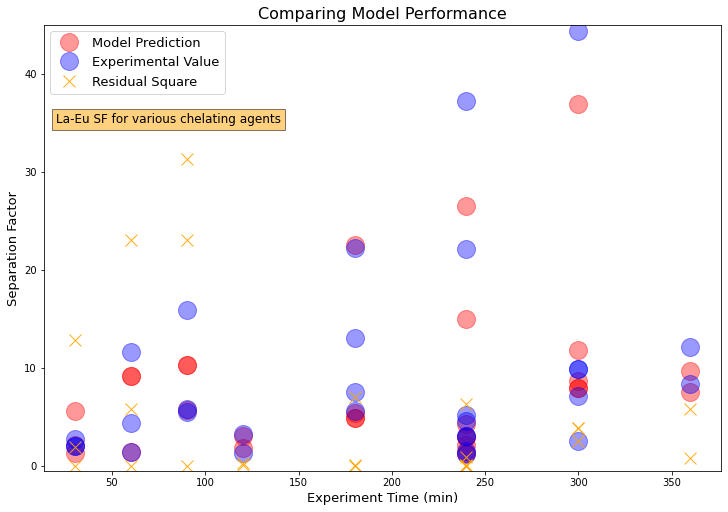

In [ ]:
y_pred = DNN_model.predict(x_eval, batch_size=None, verbose=0)
i =0
RSS=[]
for i in range(len(y_eval)):
  RSS.append(np.square(float(y_eval[i])-float(y_pred[i])))
  i += 1
#print(RSS)

#Now plot the original SF vs predicted SF
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(10, 7)
ax.plot(x_eval[:,6], y_pred, 'o', color='red', markersize=18, alpha=0.4, label = 'Model Prediction')
ax.plot(x_eval[:,6], y_eval, 'o', color='blue',markersize=18, alpha=0.4, label = 'Experimental Value')
ax.plot(x_eval[:,6], RSS, 'x', color='orange', markersize=12, alpha = 0.9, label = "Residual Square" )
plt.legend(loc='best' , prop={'size': 13})
#plt.legend.FontSize = 14
plt.xlabel("Experiment Time (min)", fontsize =13)
plt.ylabel("Separation Factor", fontsize =13)
plt.title("Comparing Model Performance", fontsize =16)
ax.set_ylim([-0.5, 45])
plt.text(20, 35, 'La-Eu SF for various chelating agents', bbox=dict(facecolor='orange', alpha=0.5), FontSize=12)
fig.show()


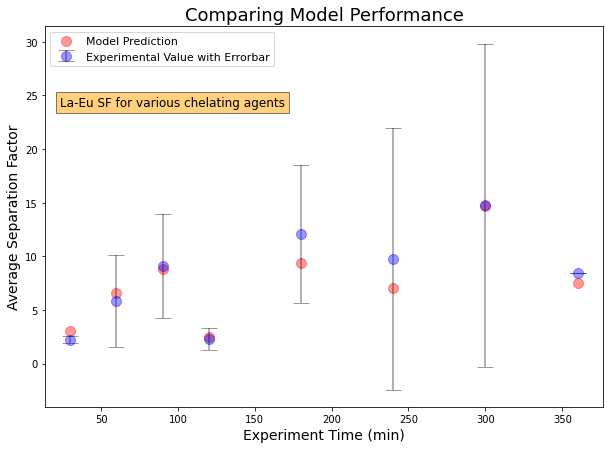

In [ ]:
#Plot average model predictions vs average experimental values with error bars
x = (np.array(x_eval[:,6])).reshape(len(x_eval[:,6]),1)

model_pred_mat = np.concatenate((x, y_pred), axis=1)
model_pred_mat = model_pred_mat[np.argsort(model_pred_mat[:, 0])]

y_eval = (np.array(y_eval.reshape(len(x_eval[:,6]), 1)))

exp_mat = np.concatenate((x, y_eval), axis=1)
exp_mat = exp_mat[np.argsort(exp_mat[:, 0])]

#uncomment if you want to see the matrices for the model prediction and experimental values
#print(exp_mat)
#print(model_pred_mat)

#Now we need to group each unique time point
t_groups, indices, counts = np.unique(model_pred_mat[:,0], return_index=True, return_counts=True)
#avg = np.empty(len(t_groups))
#std_dev = np.empty(len(t_groups))

#print(counts)
def avg_std(arr):
  j = 0
  avg = np.empty(len(t_groups))
  std_dev = np.empty(len(t_groups))
  for j in range(len(t_groups)):
    if j == len(indices)-1:
      end = -1
    else:
      end = indices[j+1]
    #uncomment to debug/ensure we sliced the array properly
    #start = indices[j]
    #print("start: ", start, "end: ", end)
    avg[j] = np.average(arr[indices[j]:end,1])
    std_dev[j] = np.std(arr[indices[j]:end,1])
    j += j
  return avg, std_dev

avg_mod, std = avg_std(model_pred_mat)
avg_exp, yerr = avg_std(exp_mat)

#print(avg_mod.reshape(len(t_groups),1))
#print("\nindices: ", indices)

#make sure they're in the correct shape for plotting
yerr.reshape(len(indices),1)
avg_mod.reshape(len(indices),1)
plt.figure(figsize=(10,7))
plt.errorbar(t_groups, avg_exp, yerr=yerr, fmt='o', markersize=10, alpha=0.4, c='blue', ecolor='black', capsize=8, label='Experimental Value with Errorbar')
plt.scatter(t_groups, avg_mod, marker='o', c='red', s=100, alpha=0.4, label='Model Prediction')
plt.legend(loc='best', fontsize=11)
plt.xlabel("Experiment Time (min)", fontsize =14)
plt.ylabel("Average Separation Factor", fontsize =14)
plt.title("Comparing Model Performance", fontsize =18)
plt.text(23, 24, 'La-Eu SF for various chelating agents', bbox=dict(facecolor='orange', alpha=0.5), FontSize=12)
fig.show()

Percent error:  0.19266043639764546


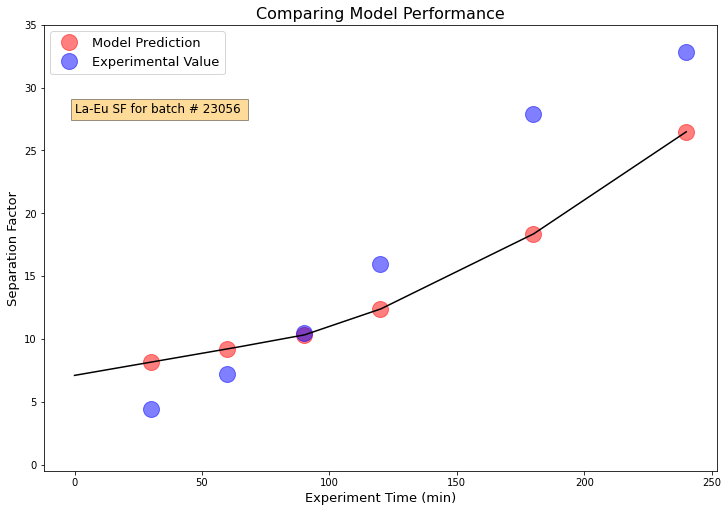

In [ ]:
batch = pd.read_csv("23056_pred.csv")
batch['LREE'] = batch['LREE'].map({1: "La"})
batch['HREE'] = batch['HREE'].map({1: "Eu"})
batch['chelant'] = batch['chelant'].map({4: "HEDTA"})
batch = pd.get_dummies(batch, prefix='', prefix_sep='')

batch_y = batch.pop('SF').to_numpy()
batch_x = batch.to_numpy()
batch_details = 'HEDTA, 1:1, 825, 825, 10 V, initial volume = 1300 mL'
#print (batch_x)

batch_pred = DNN_model.predict(batch_x, batch_size=None, verbose=0)

fig, ax1 = plt.subplots(constrained_layout=True)
fig.set_size_inches(10, 7)
ax1.plot(batch_x[:,6], batch_pred, 'o', color='red', markersize=16, alpha=0.5, label = 'Model Prediction')
ax1.plot(batch_x[:,6], batch_y, 'o', color='blue',markersize=16, alpha=0.5, label = 'Experimental Value')

batch_x = batch_x[:,6].squeeze()
batch_pred = np.reshape(batch_pred, (6,))
interp = interp1d(batch_x, batch_pred, fill_value="extrapolate")
xnew = np.linspace(0, 240, 2400)
ax1.plot(xnew, interp(xnew), color='black')

plt.legend(loc='best' , prop={'size': 13})
#plt.legend.FontSize = 14
plt.xlabel("Experiment Time (min)", fontsize =13)
plt.ylabel("Separation Factor", fontsize =13)
plt.title("Comparing Model Performance", fontsize =16)
ax1.set_ylim([-0.5, 35])
plt.text(0, 28, 'La-Eu SF for batch # 23056 ', bbox=dict(facecolor='orange', alpha=0.4), FontSize=12)
print('Percent error: ', str(abs((batch_pred[-1]-batch_y[-1])/batch_y[-1])))
fig.show()